<a href="https://colab.research.google.com/github/JeLaKo/apple-tree-disease/blob/main/adjustedsamples_MLP(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the data directly through Kaggle's API

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install -U -q kaggle==1.5.8

     |████████████████████████████████| 59 kB 4.5 MB/s 


In [3]:
%cd /content/gdrive/MyDrive/MLP/

/content/gdrive/MyDrive/MLP


In [4]:
import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/MLP/"
! kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [05:37<00:00, 24.4MB/s]
100% 14.9G/14.9G [05:37<00:00, 47.4MB/s]


In [ ]:
! unzip plant-pathology-2021-fgvc8.zip -d train

Archive:  plant-pathology-2021-fgvc8.zip
replace train/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Data processing


In [5]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

%cd /content/gdrive/MyDrive/MLP/train/

/content/gdrive/MyDrive/MLP/train


In [6]:
df = pd.read_csv('train.csv')
#print(df.head())

# df_test = pd.read_csv('sample_submission.csv')
# print(df_test.head())

In [7]:
new_labels = df['labels'].to_list()

for i in range(len(new_labels)):
  if new_labels[i] == 'scab frog_eye_leaf_spot complex' or new_labels[i] == 'scab frog_eye_leaf_spot':
    new_labels[i] = 'scab'
  elif new_labels[i] == 'frog_eye_leaf_spot complex':
    new_labels[i] = 'frog_eye_leaf_spot'
  elif new_labels[i] == 'powdery_mildew complex':
    new_labels[i] = 'powdery_mildew'
  elif new_labels[i] == 'rust complex' or new_labels[i] == 'rust frog_eye_leaf_spot':
    new_labels[i] = 'rust'


In [8]:
df['adjusted labels'] = np.array(new_labels)
df = df.drop('labels', axis = 1)

#print(df)

In [9]:
def sample(df, sample_size):
  """
  This function gets an equal sample inclusive of all classes from the input dataframe
  """
  df_sampled = []
  classes = df['adjusted labels'].unique()

  for i in classes:
      g = df[df['adjusted labels'] == i].sample(sample_size)
      df_sampled.append(g)

  df_sampled = pd.concat(df_sampled)
  return df_sampled

df_sampled = sample(df, 1184)
print(df_sampled)

                      image adjusted labels
3233   998945fcd68885bd.jpg         healthy
8101   b8fcdeb458998095.jpg         healthy
8644   bda9a5decc242c94.jpg         healthy
17290  f8b8d97c1a1c12f1.jpg         healthy
9705   c332cb3a8f720d27.jpg         healthy
...                     ...             ...
11860  d2ad07897e60c9bc.jpg  powdery_mildew
3318   9a8967ca9bddc144.jpg  powdery_mildew
2727   958e186f17977261.jpg  powdery_mildew
3743   9f1061a618f3fcc9.jpg  powdery_mildew
14212  e32938df4d780ea4.jpg  powdery_mildew

[7104 rows x 2 columns]


In [10]:
def one_hot(df):
  """
  This function returns all classes and combination of classes found in the input-dataframe, and returns
  the one-hot encoded version
  """
  one_hot = pd.get_dummies(df['adjusted labels'])
  df = df.drop('adjusted labels', axis = 1)
  df = df.join(one_hot)
  return df

df_onehot = one_hot(df_sampled)
#print(df_onehot)

# df_test = one_hot(df_test)
# print(df_test.head())

In [11]:
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, preprocessing

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

In [ ]:
# convert dictionary into a hashable type
df_dict = df_onehot.set_index('image').T.to_dict('list')

# gather names of all images in the image-directory
train_images = os.listdir('train_images/')

# # empty column for the actual images
# df_onehot["image_pixels"] = 0

images = []
# find corresponding key to image from directory, and add that image to a list
for image in df_dict.keys():
  if image in train_images:
    img = cv2.imread('train_images/' + image)
    img = cv2.resize(img, (96, 96)) 
    images.append(img)

labels = list(df_dict.values())

In [ ]:
images = np.array(images)
labels = np.array(labels)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.3, random_state=42)

288
288
Epoch 1/20
21/21 [==============================] - 35s 43ms/step - loss: 4.0614 - accuracy: 0.1012 - val_loss: 2.4842 - val_accuracy: 0.1111
Epoch 2/20
21/21 [==============================] - 1s 24ms/step - loss: 2.4577 - accuracy: 0.1369 - val_loss: 2.4572 - val_accuracy: 0.0938
Epoch 3/20
21/21 [==============================] - 1s 25ms/step - loss: 2.3468 - accuracy: 0.1696 - val_loss: 2.4378 - val_accuracy: 0.1389
Epoch 4/20
21/21 [==============================] - 1s 24ms/step - loss: 2.1777 - accuracy: 0.2336 - val_loss: 2.4549 - val_accuracy: 0.1354
Epoch 5/20
21/21 [==============================] - 1s 24ms/step - loss: 1.8466 - accuracy: 0.3914 - val_loss: 2.4729 - val_accuracy: 0.2014
Epoch 6/20
21/21 [==============================] - 1s 24ms/step - loss: 1.3291 - accuracy: 0.5833 - val_loss: 2.5677 - val_accuracy: 0.2188
Epoch 7/20
21/21 [==============================] - 0s 22ms/step - loss: 0.6985 - accuracy: 0.8065 - val_loss: 2.9617 - val_accuracy: 0.2431
Epoc

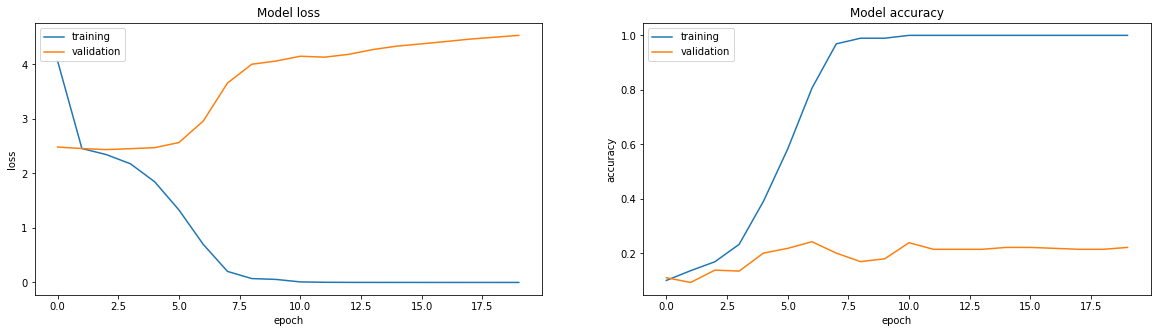

9/9 [==============================] - 0s 16ms/step - loss: 4.5340 - accuracy: 0.2222
Validation Accuracy: 0.2222222238779068


In [ ]:

# Define Sequential model
model = models.Sequential()

# create convolutional layer and max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# create convolutional layer (larger) and max pooling layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

# apply softmax activation for final layer classification
model.add(layers.Dense(12, activation='softmax'))

# normalize input data: set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# run training and evaluation function
train_and_evaluate(model, x_train, y_train, x_val, y_val, preprocess)

In [ ]:
model.summary()

In [ ]:
import seaborn as sns
import tensorflow as tf
from tensorflow import math as tfmath

classes = df['adjusted labels'].unique()
x_test_flat = x_train.reshape(x_val.shape[0], (96, 96, 3))

y_true = tf.argmax(y_val, axis=1)
y_pred = tf.argmax(model(x_test_flat), axis=1)

conf_matrix = tfmath.confusion_matrix(y_true, y_pred, num_classes=6)

ax = sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

print(conf_matrix)